En esta parte se utilizará otro conjunto muy conocido de datos para aprendizaje, que consiste también de textos en inglés. Se trata de un conjunto de noticias de prensa de la Agencia Reuters, *Reuters-21578 *, https://kdd.ics.uci.edu/databases/reuters21578/reuters21578.html

Las noticias han sido categorizadas a mano, con etiquetas de varios tipos, incluyendo *temas, lugares, organizaciones, personas* y otros criterios. Están en formato SGML, las etiquetas aparecen embebidas en el texto. Existe documentación en el archivo README de la distribución.

Nos interesaremos en el tipo de etiqueta *temas (en inglés en los textos topics)*. El objetivo es nuevamente aprender los temas a partir de los textos de las noticias, con la diferencia de que este es un problema multi-etiqueta : cada noticia puede tener varios temas. En vez de resolver el problema multi-etiqueta inicial (con más de 100 tópicos distintos) les pedimos que lo transformen según las siguientes simplificaciones: considere solo los 3 temas más frecuentes, y transforme el problema multi-etiqueta en 3 problemas de clasificación binaria

No se realiza para esta parte una especificación detallada, sino que les pedimos a Uds. que armen los pasos de una solución y definan el detalle del notebook para esta parte. Mínimamente se espera que procesen la entrada SGML, y encuentren algún modo de enfocar el problema multi-etiqueta en la versión simplificada. Se debe proponer algún modo de tratar el texto, con eventuales mejoras respecto a la vectorización de la parte 1. Se deben aplicar clasificadores y medir su performance, mínimamente con precision, recall y medida-F. Finalmente, se espera una discusión detallada de todo lo realizado y eventuales propuestas de mejora.

Puntos a tener en cuenta del conjunto de datos:
* En Topics dentro de la etiqueta <REUTERS> puede haber:
    * YES: Tiene al menos una categoría(puede existir algún error y no tener ningúna categoria)
    * NO: No tiene categoría(puede existir algún error y tener alguna categoria, supuestamente en esta versión no sucede)
    * BYPASS: No está indexado, no se verificó la categoría
* Hay etiquetas que dividen el conjunto en train y test
* Etiquetas:
    * <TOPICS>, </TOPICS> [ONCE, SAMELINE]: Lista de categorias. Si hay alguna estan delimitadas por <D></D>.
    * <UNKNOWN>, </UNKNOWN> metadatos desconocidos
    * <TEXT>, </TEXT> cuerpo del texto

##1

Se cargan los archivos a memoria, con la librería BeautifulSoup se parsea cada documento como xml dividiendo los documentos por noticias.

In [24]:
import glob
#Cargo los archivos como lista de strings en documentos
lista_nombres_archivo = glob.glob('reuters21578/*.sgm')
documentos = []
for nombre_archivo in lista_nombres_archivo:
    with open (nombre_archivo, "r") as archivo:
        documento = archivo.read()
        documentos.append(documento)

In [25]:
from BeautifulSoup import BeautifulSoup

raw_reuter_news = []
for documento in documentos:
    #coloco el contenido de los tags 'reuters' en otra lista: raw_reuter_news
    #esa lista contendra las noticias separadas en formato raw
    soup = BeautifulSoup(documento)
    for raw_reuter in soup('reuters'):
        raw_reuter_news.append(raw_reuter)

In [26]:
#verifico cantidad
print len(raw_reuter_news)
assert(21578 == len(raw_reuter_news))

21578


##2

Se cuentan la cantidad de noticias por tema y se consideran los temas más frecuentes.

In [27]:
raw_news_x_topics = {}
for raw_reuter_soup in raw_reuter_news:
    #para cada noticia
    for topics_soup in raw_reuter_soup.topics:
        #para cada topic en la lista de topics 
        #agrego la noticia a un diccionario clave topic y valor lista de noticias con ese topic.
        for topic_soup in topics_soup:
            try:
                #ya existe la lista.
                raw_news_x_topics[topic_soup].append(raw_reuter_soup)
            except KeyError:
                #es el primer valor
                raw_news_x_topics[topic_soup] = [raw_reuter_soup]

In [28]:
#ordeno el diccionario por cantidad de noticias en cada topic.
sorted_topics = sorted(raw_news_x_topics, key=lambda topic: len(raw_news_x_topics[topic]), reverse=True)
#los tres topics mas usados
primeros_topics = sorted_topics[:3]
for topic in primeros_topics:
        print topic,len(raw_news_x_topics[topic])

earn 3987
acq 2448
money-fx 801


##3

Se eliminan los metadatos y se separan los conjuntos de entrenamiento y test, para ésto se considera el atributo "LEWISPLIT". Se realizaran experimentos considerando por un lado noticias que tengan contenido más allá de la fecha y el titulo, sobre éstas noticias se experimentará tomando en cuenta sólo el contenido y tomando el contenido unido a la fecha y titulo. Por otra parte se considerarán todas las noticias aún si no tienen texto además de la fecha y titulo.

In [29]:
#ya no necesito los metadatos
#separo en train y test segun el criterio lewissplit

### PARA CUANDO BODY NO ES VACIO
#solo body
X_train = []
X_test = []
X_unused = []
#info mas completa
#body + fecha + titulo
#incluye fecha y titulo
X_train_plus = []
X_test_plus = []
X_unused_plus = []
#para etiqueta EARN
Y1_train = []
Y1_test = []
Y1_unused = []
#para etiqueta ACQ
Y2_train = []
Y2_test = []
Y2_unused = []
#para etiqueta MONEY-FX
Y3_train = []
Y3_test = []
Y3_unused = []

##### PARA CUANDO BODY ES VACIO
#incluye body o '' y fecha y titulo
X_train_b = []
X_test_b = []
X_unused_b = []
#para etiqueta EARN
Y1_train_b = []
Y1_test_b = []
Y1_unused_b = []
#para etiqueta ACQ
Y2_train_b = []
Y2_test_b = []
Y2_unused_b = []
#para etiqueta MONEY-FX
Y3_train_b = []
Y3_test_b = []
Y3_unused_b = []

#cuento los body vacios
empty_body = 0
empty_body_news = []

for raw_reuter_soup in raw_reuter_news:
    #para cada noticia
    topics_de_la_noticia = []
    for topics_soup in raw_reuter_soup.topics:
        for topic_soup in topics_soup:
            #para cada topic en la lista de topics 
            topics_de_la_noticia.append(topic_soup)
    #veo si tiene las primeras categorias
    es_earn = 1 if u'earn' in topics_de_la_noticia else 0
    es_acq = 1 if u'acq' in topics_de_la_noticia else 0
    es_money_fx = 1 if u'money-fx' in topics_de_la_noticia else 0
    #extraigo contenido
    body = raw_reuter_soup.find('body').text if raw_reuter_soup.find('body') is not None else None
    title = raw_reuter_soup.find('title').text if raw_reuter_soup.find('title') is not None else None
    date = raw_reuter_soup.find('dateline').text if raw_reuter_soup.find('dateline') is not None else None
    ## BODY NO VACIO
    if body is not None: 
        #conjunto entrenamiento
        if raw_reuter_soup['lewissplit'] == 'TRAIN':
            X_train.append(body)
            X_train_plus.append('\n'.join([title,body,date]))
            Y1_train.append(es_earn)
            Y2_train.append(es_acq)
            Y3_train.append(es_money_fx)
        #conjunto test
        elif raw_reuter_soup['lewissplit'] == 'TEST':
            X_test.append(body)
            X_test_plus.append('\n'.join([title,body,date]))
            Y1_test.append(es_earn)
            Y2_test.append(es_acq)
            Y3_test.append(es_money_fx)
        #otro
        else:
            X_unused.append(body)
            X_unused_plus.append('\n'.join([title,body,date]))
            Y1_unused.append(es_earn)
            Y2_unused.append(es_acq)
            Y3_unused.append(es_money_fx)
    ## BODY VACIO
    else: 
        empty_body = empty_body + 1
        empty_body_news.append(raw_reuter_soup)
    ## SIEMPRE
    #conjunto entrenamiento
    if raw_reuter_soup['lewissplit'] == 'TRAIN':
        X_train_b.append('\n'.join(filter(None,[title,date])))
        Y1_train_b.append(es_earn)
        Y2_train_b.append(es_acq)
        Y3_train_b.append(es_money_fx)
    #conjunto test
    elif raw_reuter_soup['lewissplit'] == 'TEST':
        X_test_b.append('\n'.join(filter(None,[title,date])))
        Y1_test_b.append(es_earn)
        Y2_test_b.append(es_acq)
        Y3_test_b.append(es_money_fx)
    #otro
    else:
        X_unused_b.append('\n'.join(filter(None,[title,date])))
        Y1_unused_b.append(es_earn)
        Y2_unused_b.append(es_acq)
        Y3_unused_b.append(es_money_fx)

In [30]:
#verifico cantidad noticias
news_n_topics = X_train + X_test + X_unused
total = len(news_n_topics) + empty_body
print "Total: ", total
assert(21578 == total)
print
print "### Noticias con BODY: ",len(news_n_topics)
#verifico cantidad earn
print "EARN: ",sum(Y1_train+Y1_test+Y1_unused)
#verifico cantidad acq
print "ACQ: ",sum(Y2_train+Y2_test+Y2_unused)
#verifico cantidad money-fx
print "MONEY-FX", sum(Y3_train+Y3_test+Y3_unused)
len_X_train = len(X_train)
len_X_test = len(X_test)
len_X_unused = len(X_unused)
print
print "Train: ",len_X_train
print "Test: ",len_X_test
print "Unused: ",len_X_unused
assert(len(news_n_topics)==len_X_train+len_X_test+len_X_unused)
assert(len_X_train==len(Y1_train))
assert(len_X_train==len(Y2_train))
assert(len_X_train==len(Y3_train))
assert(len_X_test==len(Y1_test))
assert(len_X_test==len(Y2_test))
assert(len_X_test==len(Y3_test))
print
news_n_topics_b = X_train_b + X_test_b + X_unused_b
print "### Noticias con o sin BODY: ",len(news_n_topics_b)
#verifico cantidad earn
print "EARN: ",sum(Y1_train_b+Y1_test_b+Y1_unused_b)
#verifico cantidad acq
print "ACQ: ",sum(Y2_train_b+Y2_test_b+Y2_unused_b)
#verifico cantidad money-fx
print "MONEY-FX", sum(Y3_train_b+Y3_test_b+Y3_unused_b)
len_X_train_b = len(X_train_b)
len_X_test_b = len(X_test_b)
len_X_unused_b = len(X_unused_b)
print
print "Train: ",len_X_train_b
print "Test: ",len_X_test_b
print "Unused: ",len_X_unused_b

Total:  21578

### Noticias con BODY:  19043
EARN:  3776
ACQ:  2210
MONEY-FX 684

Train:  12865
Test:  5458
Unused:  720

### Noticias con o sin BODY:  21578
EARN:  3987
ACQ:  2448
MONEY-FX 801

Train:  14668
Test:  6188
Unused:  722


In [31]:
#Organizacion de experimentos

## NOTICIAS CON BODY
Experimentos_A = [
    ("EARN",X_train, X_test, Y1_train, Y1_test),
    ("ACQ",X_train, X_test, Y2_train, Y2_test),
    ("MONEY-FX",X_train, X_test, Y3_train, Y3_test)
]

## NOTICIAS CON BODY CONSIDERANDO FECHA Y TITULO
Experimentos_B = [
    ("EARN",X_train_plus, X_test_plus, Y1_train, Y1_test),
    ("ACQ",X_train_plus, X_test_plus, Y2_train, Y2_test),
    ("MONEY-FX",X_train_plus, X_test_plus, Y3_train, Y3_test)
]

## NOTICIAS CON O SIN BODY CONSIDERANDO FECHA Y TITULO
Experimentos_C = [
    ("EARN",X_train_b, X_test_b, Y1_train_b, Y1_test_b),
    ("ACQ",X_train_b, X_test_b, Y2_train_b, Y2_test_b),
    ("MONEY-FX",X_train_b, X_test_b, Y3_train_b, Y3_test_b)
]

##4

Se transforman los ejemplos al modelo de **Bag-of-words**, se utilizan los métodos **Count Vectorizer** y **TfidVectorizer** vistos en la primera parte y se incorpora el **HashVectorizer**. Además se utiliza una variación de CountVectorizer ajustando el parámetro min_df a 0.1 que hace que se ignoren los término que aparecen menos que 10% de las veces.

In [64]:
#Vectorizacion
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
count_vect2 = CountVectorizer(min_df=0.1)
tidf_vect = TfidfVectorizer()
hash_vect = HashingVectorizer(non_negative=True)
Vectorizadores = [    
    ("TfidfVectorizer", tidf_vect),
    ("CountVectorizer", count_vect),
    ("CountVectorizer2", count_vect2),
    ("HashingVectorizer", hash_vect)
]

##5 Ajuste Parámetrico

Se experimentará con varios clasificadores, se eligieron las versiones con parámetros por defecto de  **MultinomialNB**, **SGDClassifier**,**Perceptron** y **PassiveAggressiveClassifier** además se incorpora una variacion de PassiveAggressiveClassifier modificando el parámetro loss.

In [63]:
#Comparación de diferentes clasificadores
#Fuente: http://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html

# Creación de clasificadores
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB

"""
lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)
"""
multiNB = MultinomialNB()
sgd = SGDClassifier()
perceptron = Perceptron()
passiveaggclass = PassiveAggressiveClassifier()
passiveaggclass2 = PassiveAggressiveClassifier(loss='squared_hinge')

Clasificadores = [    
    ("MultinomialNB", multiNB),
    ("SGD", sgd),
    ("Perceptron", perceptron),
    ("SGDClassifier", sgd),
    ("Passive-Aggressive I", passiveaggclass),
    ("Passive-Aggressive II", passiveaggclass2)
]

In [74]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
resultados = []

#Funcion que recibe 
#X conj entrenamiento
#Y conj test
#V conj vectorizadores
#C conj clasificadores
def run(train_data,train_target,test_data,test_target,V,C,matrix = True):
    resultado = []
    for nomvect, vectorizador in V:
        #Vectorizo
        X_train = vectorizador.fit_transform(train_data)        
        X_test = vectorizador.transform(test_data)
        f1_list = []
        for nomclf,clasificador in C:
            if (matrix):
                print "F1", "C: " + nomclf + ", V: " + nomvect,   
            if nomclf == 'RandomForest':
                X_train = X_train.toarray()
                X_test = X_test.toarray()
            #Entreno
            clasificador.fit(X_train, train_target)
            #Predigo Test
            prediccion = 0
            prediccion = clasificador.predict(X_test)  
            #Resultados
            f1 = metrics.f1_score(test_target, prediccion, average='weighted')
            f1_list.append(f1)
            if (matrix):
                print f1
                #print confusion_matrix(test_target,prediccion)
        resultado.append(f1_list)
    noms_vects, e = zip(*V)
    noms_clsfs, e = zip(*C)
    return (noms_vects,noms_clsfs,resultado)

In [53]:
%matplotlib inline
from matplotlib.pyplot import cm
import numpy as np
import matplotlib.pyplot as plt

##Funcion para graficar y comparar
##los parametros de vectorizadores y clasificadores.
def plot(clasificadores, vectorizadores, medidaf):
    
    color=cm.rainbow(np.linspace(0,1,100))
    indices = np.arange(len(clasificadores))

    plt.figure(figsize=(3*len(clasificadores), 8))
    c = 1
    contador = 0
    i = 0
    for vect in vectorizadores:
        plt.barh(indices + i, medidaf[contador], .2, label=vect, color=color[c])
        c=c+10
        contador = contador + 1
        i = i + .3
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clasificadores):
        plt.text(-0.1, i, c)

    plt.title("Medida-f por metodo y por clasificador.")
    plt.show()

###5.A
####El experimento A corresponde a los ejemplos que tenian body no vacío considerando solo el body.

###### Categoria: EARN

F1 C: MultinomialNB, V: TfidfVectorizer 0.862068965517
F1 C: SGD, V: TfidfVectorizer 0.84827879303
F1 C: Perceptron, V: TfidfVectorizer 0.832813196612
F1 C: SGDClassifier, V: TfidfVectorizer 0.84827879303
F1 C: Passive-Aggressive I, V: TfidfVectorizer 0.821052631579
F1 C: Passive-Aggressive II, V: TfidfVectorizer 0.821760283061
F1 C: MultinomialNB, V: CountVectorizer 0.81619165634
F1 C: SGD, V: CountVectorizer 0.805042016807
F1 C: Perceptron, V: CountVectorizer 0.815623687526
F1 C: SGDClassifier, V: CountVectorizer 0.805042016807
F1 C: Passive-Aggressive I, V: CountVectorizer 0.828397565923
F1 C: Passive-Aggressive II, V: CountVectorizer 0.828397565923
F1 C: MultinomialNB, V: CountVectorizer2 0.807106598985
F1 C: SGD, V: CountVectorizer2 0.776872332169
F1 C: Perceptron, V: CountVectorizer2 0.760242792109
F1 C: SGDClassifier, V: CountVectorizer2 0.776872332169
F1 C: Passive-Aggressive I, V: CountVectorizer2 0.836427939876
F1 C: Passive-Aggressive II, V: CountVect

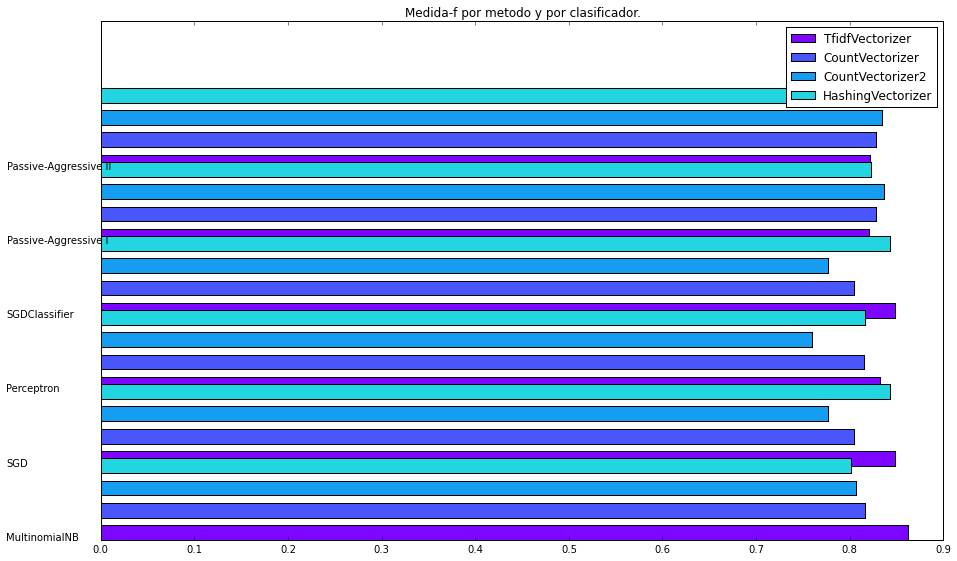

###### Categoria: ACQ

F1 C: MultinomialNB, V: TfidfVectorizer 0.00928792569659
F1 C: SGD, V: TfidfVectorizer 0.798004987531
F1 C: Perceptron, V: TfidfVectorizer 0.784
F1 C: SGDClassifier, V: TfidfVectorizer 0.798004987531
F1 C: Passive-Aggressive I, V: TfidfVectorizer 0.807045636509
F1 C: Passive-Aggressive II, V: TfidfVectorizer 0.805444355484
F1 C: MultinomialNB, V: CountVectorizer 0.627021387585
F1 C: SGD, V: CountVectorizer 0.790024135157
F1 C: Perceptron, V: CountVectorizer 0.779261586803
F1 C: SGDClassifier, V: CountVectorizer 0.790024135157
F1 C: Passive-Aggressive I, V: CountVectorizer 0.786699107867
F1 C: Passive-Aggressive II, V: CountVectorizer 0.786699107867
F1 C: MultinomialNB, V: CountVectorizer2 0.477701543739
F1 C: SGD, V: CountVectorizer2 0.27935723115
F1 C: Perceptron, V: CountVectorizer2 0.54616240267
F1 C: SGDClassifier, V: CountVectorizer2 0.27935723115
F1 C: Passive-Aggressive I, V: CountVectorizer2 0.503896103896
F1 C: Passive-Aggressive II, V: CountVectorizer2 

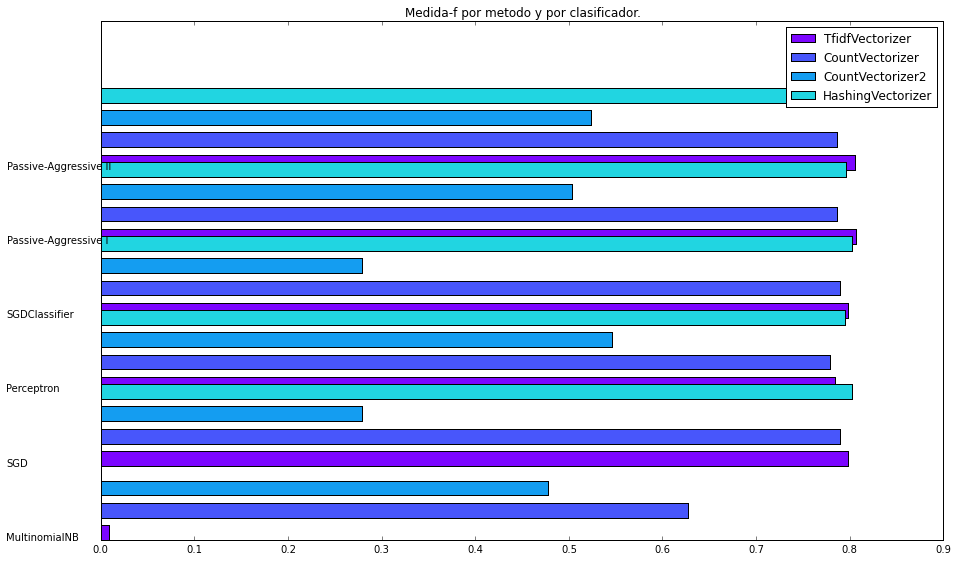

###### Categoria: MONEY-FX

F1 C: MultinomialNB, V: TfidfVectorizer 0.0
F1 C: SGD, V: TfidfVectorizer 0.566371681416
F1 C: Perceptron, V: TfidfVectorizer 0.570342205323
F1 C: SGDClassifier, V: TfidfVectorizer 0.566371681416
F1 C: Passive-Aggressive I, V: TfidfVectorizer 0.608
F1 C: Passive-Aggressive II, V: TfidfVectorizer 0.588709677419
F1 C: MultinomialNB, V: CountVectorizer 0.688
F1 C: SGD, V: CountVectorizer 0.574898785425
F1 C: Perceptron, V: CountVectorizer 0.571428571429
F1 C: SGDClassifier, V: CountVectorizer 0.574898785425
F1 C: Passive-Aggressive I, V: CountVectorizer 0.565217391304
F1 C: Passive-Aggressive II, V: CountVectorizer 0.571428571429
F1 C: MultinomialNB, V: CountVectorizer2 0.244660194175
F1 C: SGD, V: CountVectorizer2 0.245454545455
F1 C: Perceptron, V: CountVectorizer2 0.185792349727
F1 C: SGDClassifier, V: CountVectorizer2 0.245454545455
F1 C: Passive-Aggressive I, V: CountVectorizer2 0.280542986425
F1 C: Passive-Aggressive II, V: CountVectorizer2 0.293577981651

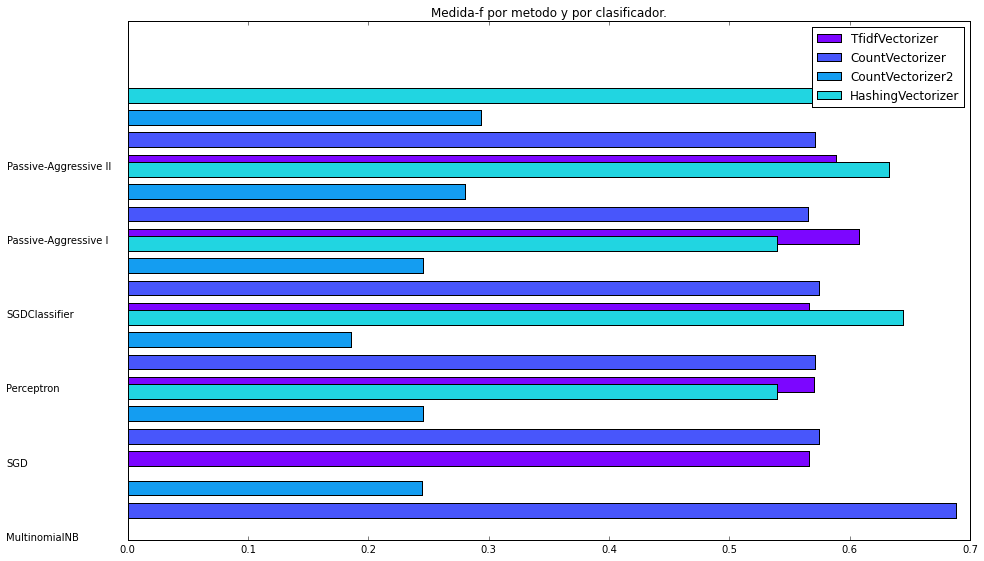

In [75]:
for nomcat,X_train,X_test,y_train,y_test in Experimentos_A:
    print "###### Categoria: " + nomcat
    print
    noms_vects,nomclf,resultados = run(X_train,y_train,X_test,y_test,Vectorizadores,Clasificadores,True)
    plot(nomclf, noms_vects, resultados)

###5.B
####El experimento B corresponde a los ejemplos que tenian body no vacío considerando el body, la fecha y el título.

###### Categoria: EARN

F1 C: MultinomialNB, V: TfidfVectorizer 0.860735910573
F1 C: SGD, V: TfidfVectorizer 0.851443123939
F1 C: Perceptron, V: TfidfVectorizer 0.762122598353
F1 C: SGDClassifier, V: TfidfVectorizer 0.851443123939
F1 C: Passive-Aggressive I, V: TfidfVectorizer 0.808939526731
F1 C: Passive-Aggressive II, V: TfidfVectorizer 0.814167031045
F1 C: MultinomialNB, V: CountVectorizer 0.814754098361
F1 C: SGD, V: CountVectorizer 0.775175644028
F1 C: Perceptron, V: CountVectorizer 0.702091189578
F1 C: SGDClassifier, V: CountVectorizer 0.775175644028
F1 C: Passive-Aggressive I, V: CountVectorizer 0.835038886615
F1 C: Passive-Aggressive II, V: CountVectorizer 0.835038886615
F1 C: MultinomialNB, V: CountVectorizer2 0.805882352941
F1 C: SGD, V: CountVectorizer2 0.734484024972
F1 C: Perceptron, V: CountVectorizer2 0.751310861423
F1 C: SGDClassifier, V: CountVectorizer2 0.734484024972
F1 C: Passive-Aggressive I, V: CountVectorizer2 0.830713964975
F1 C: Passive-Aggressive II, V: CountV

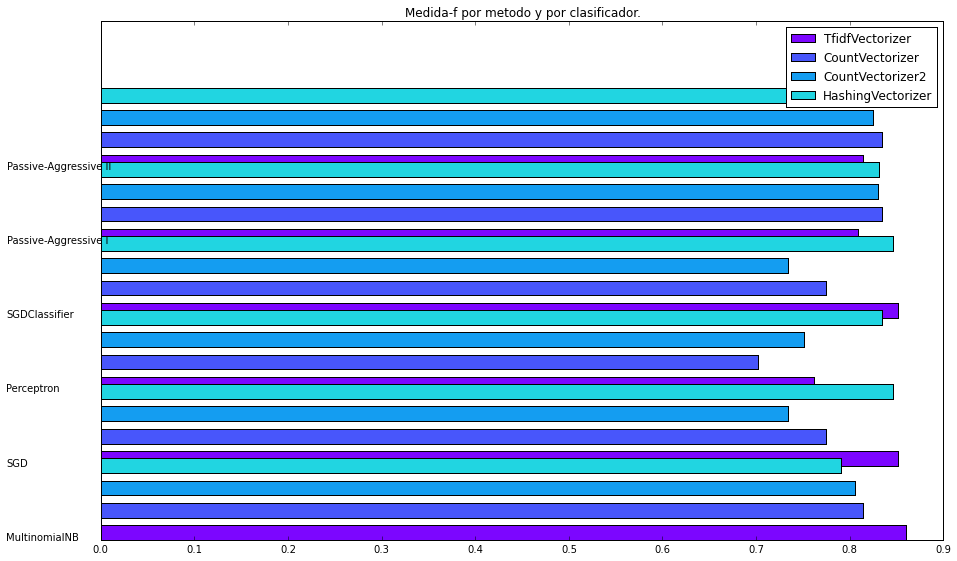

###### Categoria: ACQ

F1 C: MultinomialNB, V: TfidfVectorizer 0.0123647604328
F1 C: SGD, V: TfidfVectorizer 0.829787234043
F1 C: Perceptron, V: TfidfVectorizer 0.807395993837
F1 C: SGDClassifier, V: TfidfVectorizer 0.829787234043
F1 C: Passive-Aggressive I, V: TfidfVectorizer 0.826188620421
F1 C: Passive-Aggressive II, V: TfidfVectorizer 0.830601092896
F1 C: MultinomialNB, V: CountVectorizer 0.64
F1 C: SGD, V: CountVectorizer 0.805778491172
F1 C: Perceptron, V: CountVectorizer 0.758043758044
F1 C: SGDClassifier, V: CountVectorizer 0.805778491172
F1 C: Passive-Aggressive I, V: CountVectorizer 0.821729150727
F1 C: Passive-Aggressive II, V: CountVectorizer 0.821729150727
F1 C: MultinomialNB, V: CountVectorizer2 0.466945606695
F1 C: SGD, V: CountVectorizer2 0.557823129252
F1 C: Perceptron, V: CountVectorizer2 0.57223796034
F1 C: SGDClassifier, V: CountVectorizer2 0.557823129252
F1 C: Passive-Aggressive I, V: CountVectorizer2 0.492165898618
F1 C: Passive-Aggressive II, V: CountVectorizer2 

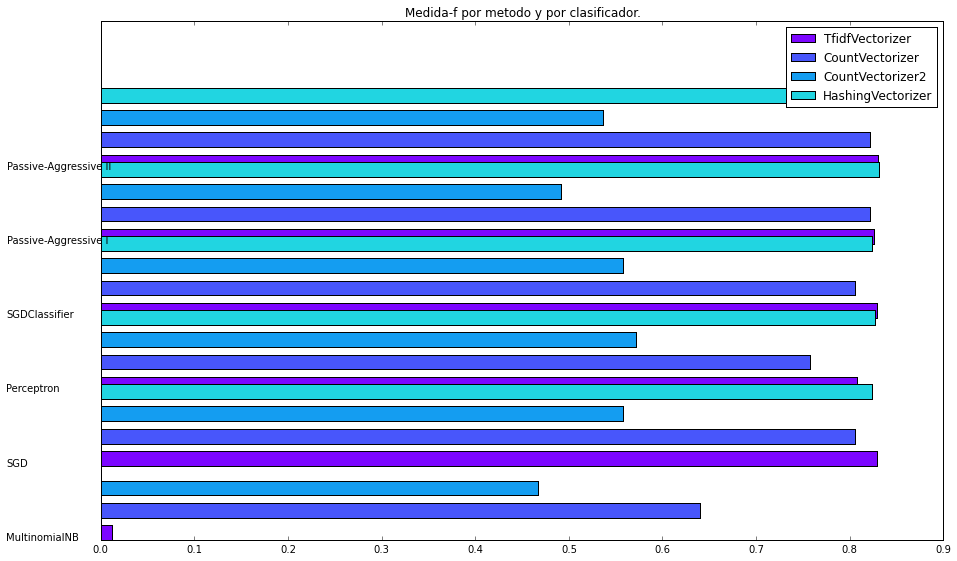

###### Categoria: MONEY-FX

F1 C: MultinomialNB, V: TfidfVectorizer 0.0
F1 C: SGD, V: TfidfVectorizer 0.591304347826
F1 C: Perceptron, V: TfidfVectorizer 0.535564853556
F1 C: SGDClassifier, V: TfidfVectorizer 0.591304347826
F1 C: Passive-Aggressive I, V: TfidfVectorizer 0.609375
F1 C: Passive-Aggressive II, V: TfidfVectorizer 0.611764705882
F1 C: MultinomialNB, V: CountVectorizer 0.677333333333
F1 C: SGD, V: CountVectorizer 0.587360594796
F1 C: Perceptron, V: CountVectorizer 0.569288389513
F1 C: SGDClassifier, V: CountVectorizer 0.587360594796
F1 C: Passive-Aggressive I, V: CountVectorizer 0.588235294118
F1 C: Passive-Aggressive II, V: CountVectorizer 0.588235294118
F1 C: MultinomialNB, V: CountVectorizer2 0.234647112741
F1 C: SGD, V: CountVectorizer2 0.245283018868
F1 C: Perceptron, V: CountVectorizer2 0.161849710983
F1 C: SGDClassifier, V: CountVectorizer2 0.245283018868
F1 C: Passive-Aggressive I, V: CountVectorizer2 0.218905472637
F1 C: Passive-Aggressive II, V: CountVectorizer2 0.

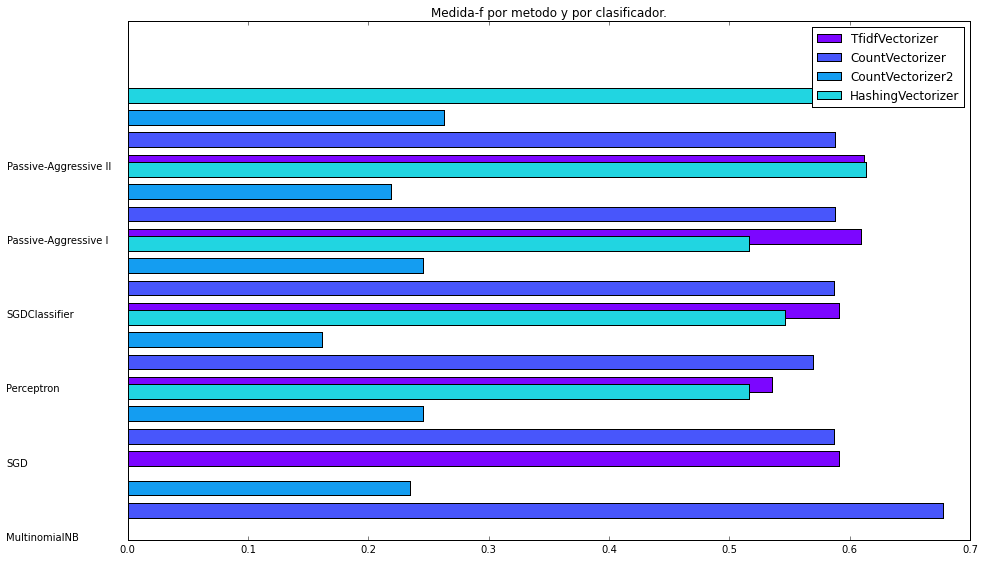

In [76]:
for nomcat,X_train,X_test,y_train,y_test in Experimentos_B:
    print "###### Categoria: " + nomcat
    print
    noms_vects,nomclf,resultados = run(X_train,y_train,X_test,y_test,Vectorizadores,Clasificadores,True)
    plot(nomclf, noms_vects, resultados)

###5.C
####El experimento C corresponde a todos los ejemplos aún teniendo el body vacío, considerando el body, la fecha y el título.

###### Categoria: EARN

F1 C: MultinomialNB, V: TfidfVectorizer 0.778021978022
F1 C: SGD, V: TfidfVectorizer 0.796637309848
F1 C: Perceptron, V: TfidfVectorizer 0.692534795445
F1 C: SGDClassifier, V: TfidfVectorizer 0.796637309848
F1 C: Passive-Aggressive I, V: TfidfVectorizer 0.754233787691
F1 C: Passive-Aggressive II, V: TfidfVectorizer 0.757052631579
F1 C: MultinomialNB, V: CountVectorizer 0.770792659118
F1 C: SGD, V: CountVectorizer 0.777511961722
F1 C: Perceptron, V: CountVectorizer 0.729064039409
F1 C: SGDClassifier, V: CountVectorizer 0.777511961722
F1 C: Passive-Aggressive I, V: CountVectorizer 0.748055987558
F1 C: Passive-Aggressive II, V: CountVectorizer 0.768922707249
F1 C: MultinomialNB, V: CountVectorizer2 0.0
F1 C: SGD, V: CountVectorizer2 0.0
F1 C: Perceptron, V: CountVectorizer2 0.0
F1 C: SGDClassifier, V: CountVectorizer2 0.0
F1 C: Passive-Aggressive I, V: CountVectorizer2 0.0
F1 C: Passive-Aggressive II, V: CountVectorizer2 0.0
F1 C: MultinomialNB, V: HashingVectorize

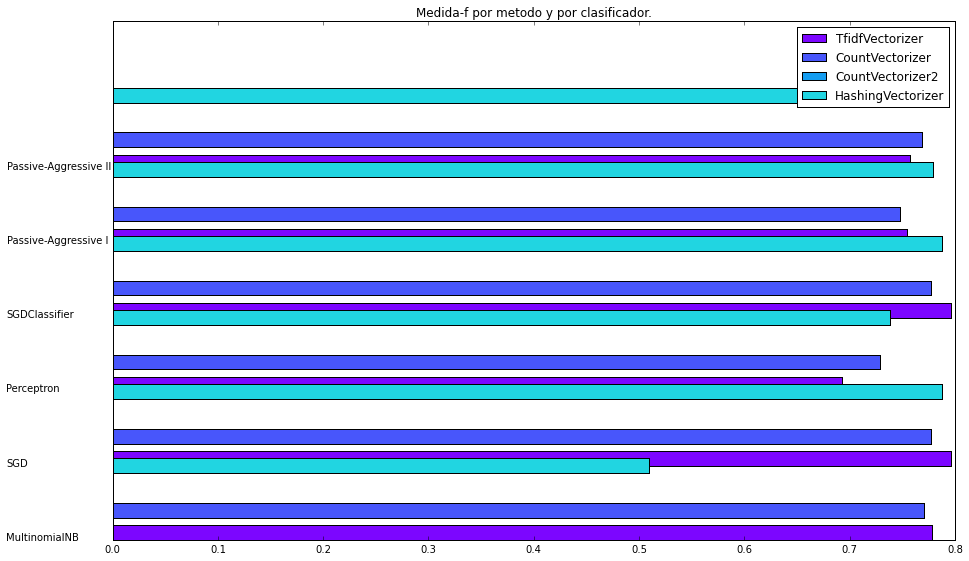

###### Categoria: ACQ

F1 C: MultinomialNB, V: TfidfVectorizer 0.127272727273
F1 C: SGD, V: TfidfVectorizer 0.770800627943
F1 C: Perceptron, V: TfidfVectorizer 0.743718592965
F1 C: SGDClassifier, V: TfidfVectorizer 0.770800627943
F1 C: Passive-Aggressive I, V: TfidfVectorizer 0.772334293948
F1 C: Passive-Aggressive II, V: TfidfVectorizer 0.773488710852
F1 C: MultinomialNB, V: CountVectorizer 0.704832713755
F1 C: SGD, V: CountVectorizer 0.762114537445
F1 C: Perceptron, V: CountVectorizer 0.688849970811
F1 C: SGDClassifier, V: CountVectorizer 0.762114537445
F1 C: Passive-Aggressive I, V: CountVectorizer 0.71838729383
F1 C: Passive-Aggressive II, V: CountVectorizer 0.75350140056
F1 C: MultinomialNB, V: CountVectorizer2 0.0
F1 C: SGD, V: CountVectorizer2 0.0
F1 C: Perceptron, V: CountVectorizer2 0.170149253731
F1 C: SGDClassifier, V: CountVectorizer2 0.0
F1 C: Passive-Aggressive I, V: CountVectorizer2 0.0925266903915
F1 C: Passive-Aggressive II, V: CountVectorizer2 0.103786816269
F1 C: Mul

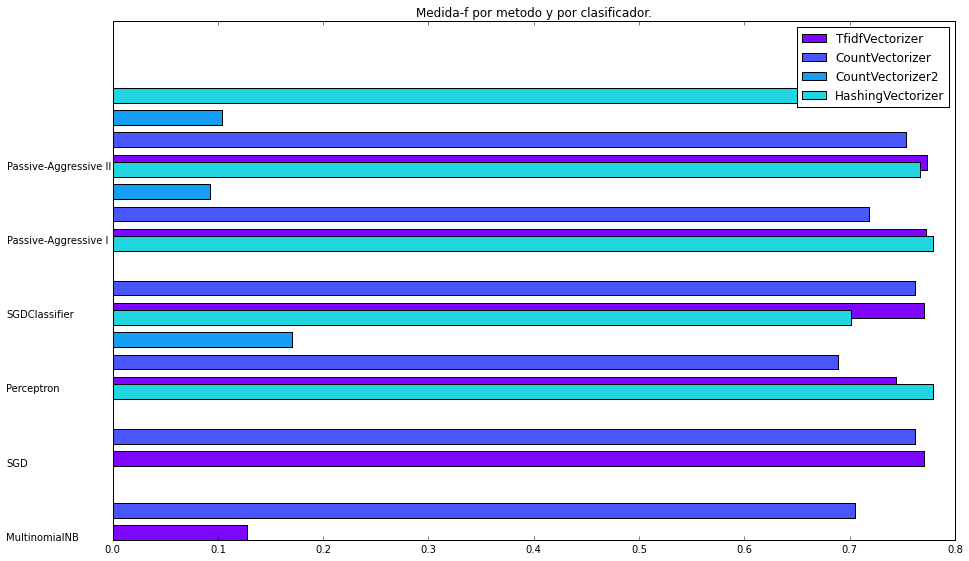

###### Categoria: MONEY-FX

F1 C: MultinomialNB, V: TfidfVectorizer 0.0
F1 C: SGD, V: TfidfVectorizer 0.447058823529
F1 C: Perceptron, V: TfidfVectorizer 0.539393939394
F1 C: SGDClassifier, V: TfidfVectorizer 0.447058823529
F1 C: Passive-Aggressive I, V: TfidfVectorizer 0.550819672131
F1 C: Passive-Aggressive II, V: TfidfVectorizer 0.535947712418
F1 C: MultinomialNB, V: CountVectorizer 0.453608247423
F1 C: SGD, V: CountVectorizer 0.545454545455
F1 C: Perceptron, V: CountVectorizer 0.507462686567
F1 C: SGDClassifier, V: CountVectorizer 0.545454545455
F1 C: Passive-Aggressive I, V: CountVectorizer 0.544
F1 C: Passive-Aggressive II, V: CountVectorizer 0.551928783383
F1 C: MultinomialNB, V: CountVectorizer2 0.0
F1 C: SGD, V: CountVectorizer2 0.0
F1 C: Perceptron, V: CountVectorizer2 0.106075216972
F1 C: SGDClassifier, V: CountVectorizer2 0.0
F1 C: Passive-Aggressive I, V: CountVectorizer2 0.0
F1 C: Passive-Aggressive II, V: CountVectorizer2 0.0
F1 C: MultinomialNB, V: HashingVectorizer 0.0

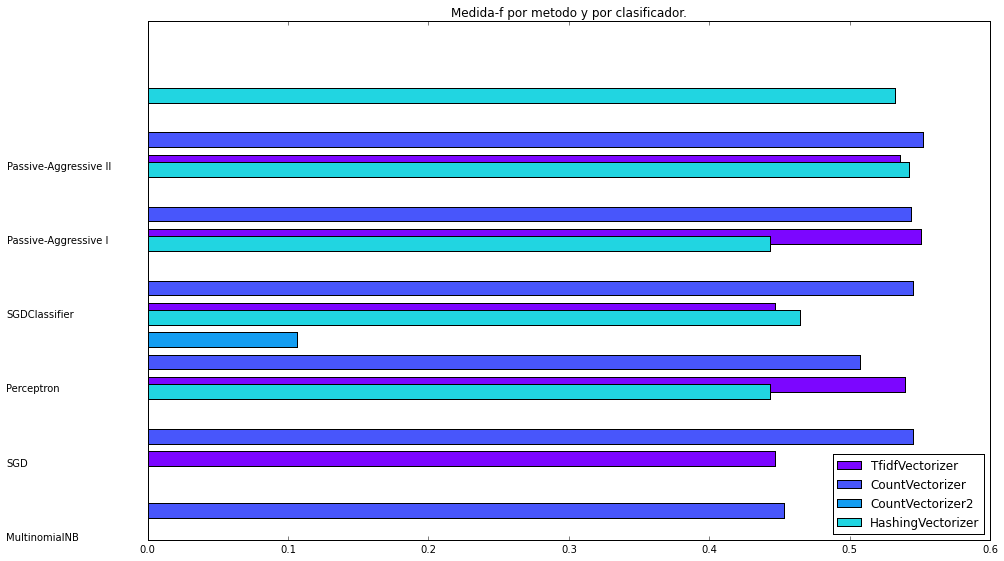

In [77]:
for nomcat,X_train,X_test,y_train,y_test in Experimentos_C:
    print "###### Categoria: " + nomcat
    print
    noms_vects,nomclf,resultados = run(X_train,y_train,X_test,y_test,Vectorizadores,Clasificadores,True)
    plot(nomclf, noms_vects, resultados)

##6 Resultados

El experimento A y B tienen resultados muy simlares para clasificar si los ejemplos pertenecen a la primer categoría mayor (**EARN**), la combinación del vectorizador TfidVectorizer y el clasificador MultinomialNB da las mejores medidas f en ambos experimentos (0.86). Para clasificar la segunda categoría la mejor combinación para el ejemplo A resultó ser la de TfidVectorizer y PassiveAggresive I (medida-f 0.80) y en el experimento B se logró mejorar esa medida con la combinación de HashVectorizer y Passive Aggresive II (medida-f 0.83). La tercera categoría fue mejor clasificada por el experimento A con la combinación HashVectorizer y PassiveAgressive I (0.63) apenas por encima del experimento B con la misma combinación (0.61).

###6. EARN 
####Se usará la combinación del vectorizador TfidVectorizer y el clasificador MultinomialNB para clasificar la categoría EARN sobre los ejemplos con body válido sólo tomando en cuenta el body.

In [91]:
from sklearn.metrics import classification_report

n,C = Clasificadores[0]
n,V = Vectorizadores[0]
nom ,X_train, X_test, Y1_train, Y1_test = Experimentos_A[0]
#Vectorizo
X_train = V.fit_transform(X_train)        
X_test = V.transform(X_test)
#Entreno
C.fit(X_train, Y1_train)
#Predigo Test
prediccion = C.predict(X_test)  
#Resultados
print confusion_matrix(Y1_test,prediccion)
print classification_report(Y1_test,prediccion)

[[4237  176]
 [ 120  925]]
             precision    recall  f1-score   support

          0       0.97      0.96      0.97      4413
          1       0.84      0.89      0.86      1045

avg / total       0.95      0.95      0.95      5458



###6. ACQ
####Se usará la combinación del vectorizador TfidVectorizer y el clasificador Passive Aggresive I para clasificar la categoría ACQ sobre los ejemplos con body válido sólo tomando en cuenta el body.

In [95]:
from sklearn.metrics import classification_report

n,C = Clasificadores[4]
n,V = Vectorizadores[0]
nom ,X_train, X_test, Y1_train, Y1_test = Experimentos_A[1]
#Vectorizo
X_train = V.fit_transform(X_train)        
X_test = V.transform(X_test)
#Entreno
C.fit(X_train, Y1_train)
#Predigo Test
prediccion = C.predict(X_test)  
#Resultados
print confusion_matrix(Y1_test,prediccion)
print classification_report(Y1_test,prediccion)

[[4713  102]
 [ 139  504]]
             precision    recall  f1-score   support

          0       0.97      0.98      0.98      4815
          1       0.83      0.78      0.81       643

avg / total       0.95      0.96      0.96      5458



###6. Money-fx
####Se usará la combinación del vectorizador HashVectorizer y el clasificador Passive Aggresive I para clasificar la categoría ACQ sobre los ejemplos con body válido sólo tomando en cuenta el body.

In [93]:
from sklearn.metrics import classification_report

n,C = Clasificadores[4]
n,V = Vectorizadores[3]
nom ,X_train, X_test, Y1_train, Y1_test = Experimentos_A[2]
#Vectorizo
X_train = V.fit_transform(X_train)        
X_test = V.transform(X_test)
#Entreno
C.fit(X_train, Y1_train)
#Predigo Test
prediccion = C.predict(X_test)  
#Resultados
print confusion_matrix(Y1_test,prediccion)
print classification_report(Y1_test,prediccion)

[[5285   31]
 [  62   80]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      5316
          1       0.72      0.56      0.63       142

avg / total       0.98      0.98      0.98      5458



##7 Conclusiones



En principio no parece ganado demasiado al incorporar la información de fecha o títulos a los ejemplos, a su vez es claro que pesa en la correctitud de la clasificación la cantidad de ejemplos con los que contaba cada categoría inicialmente (earn: 3987, acq: 2448 y money-fx: 801)

También queda claro con el experimento C que incorporar ejemplos que no tienen body válido da muy malos resultados. 

##8 Trabajo Futuro

Una posible mejora sería hacer selección de atributos considerando otras etiquetas que fueron descartadas, países, lugares, etc.

Además considerando la poca difrencia entre el experimento A y el B una mejora podría consistir en experimentar por un lado con la fecha y por otro con el título.

Sería interesante tomar otras divisiones para los conjuntos de entrenamiento y prueba, asimismo sería interesante implementar validación cruzada.